In [1]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models
import cv2
from tqdm import tqdm

In [2]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

Use OpenCV to read our target video.

In [5]:
#Load the video and count the number of frames in it
capture = cv2.VideoCapture("../data/Cannonbal.mp4")
videoFps = int(capture.get(cv2.CAP_PROP_FPS))
videoLength = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
#Check video length and assert
print("Video FPS: {}".format(videoFps))
print("Video Total Frames: {}".format(videoLength))

Video FPS: 23
Video Total Frames: 700


In [6]:
frames = []
for i in tqdm(range(videoLength)):
    success = capture.grab()
    success, frame = capture.retrieve()
    frames.append(frame)

100%|███████████████████████████████████████████████████████████████████████████████| 700/700 [00:01<00:00, 384.19it/s]


We will be needing all the frames except the first and last frame to be our Part 2 of our final video. We will save it into a video first.

In [7]:
fps = videoFps
#somehow the width is shape[1] instead of shape[0] of a frame, height is shape[0]
size = (frames[0].shape[1],frames[0].shape[0])
output_filename = "part2.avi"
fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
out = cv2.VideoWriter(output_filename, fourcc, fps, size)

for i in tqdm(range(1,len(frames)-1)):
    img=frames[i]
    out.write(img)
out.release()

100%|███████████████████████████████████████████████████████████████████████████████| 698/698 [00:05<00:00, 128.95it/s]


In [8]:
# If this cell runs into error, please rerun the cell before this
# Make a clone so that the frame can be save to a file successfully
firstFrame=frames[0].copy()
lastFrame=frames[-1].copy()
cv2.imwrite("first_frame.jpg",firstFrame)
cv2.imwrite("last_frame.jpg",lastFrame)

True

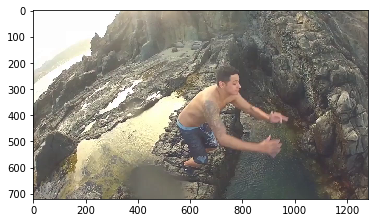

In [9]:
#Take note OpenCV read frames as BGR and matplotlib and Pillow read frames as RGB
#This is the first frame of the video
plt.imshow(cv2.cvtColor(firstFrame,cv2.COLOR_RGB2BGR))

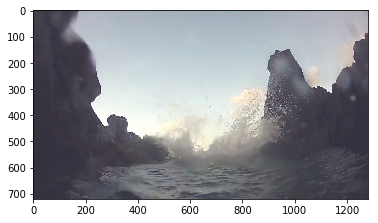

In [10]:
#This is the last frame of the video
plt.imshow(cv2.cvtColor(lastFrame,cv2.COLOR_RGB2BGR))

In [11]:
#For simplicity's sake, we will reuse the already written load_image() function to load from jpg files.

In [12]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Next, I'm loading in images by file name and forcing the style image to be the same size as the content image.

In [13]:
# load in content and style image
content1 = load_image('first_frame.jpg').to(device)
content2 = load_image('last_frame.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('images/hokusai_wave.jpg', shape=content1.shape[-2:]).to(device)

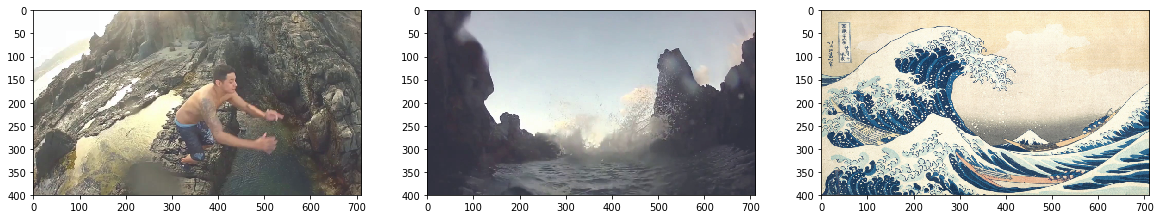

In [14]:
# display the images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
# content1,content2 and style ims side-by-side
ax1.imshow(im_convert(content1))
ax2.imshow(im_convert(content2))
ax3.imshow(im_convert(style))

## Content and Style Features

Below, complete the mapping of layer names to the names found in the paper for the _content representation_ and the _style representation_.

In [15]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [16]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [17]:
# get content and style features only once before training
content1_features = get_features(content1, vgg)
content2_features = get_features(content2, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target1 = content1.clone().requires_grad_(True).to(device)
target2 = content2.clone().requires_grad_(True).to(device)

In [18]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

In [19]:
# for displaying the target image, intermittently
# n-iteration
show_every = 30

# iteration hyperparameters
optimizer = optim.Adam([target1], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

frames1 = []
for ii in range(1, steps+1):
    
    # get the features from your target image
    target1_features = get_features(target1, vgg)
    
    # the content loss
    content_loss = torch.mean((target1_features['conv4_2'] - content1_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target1_feature = target1_features[layer]
        target1_gram = gram_matrix(target1_feature)
        _, d, h, w = target1_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target1_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # append the target image into the frames list for every n iterations
    if  ii % show_every == 0:
        frames1.append(im_convert(target1))

Prepare Part 1 of the final video, which is a original image transition to styled image.

In [20]:
fps = videoFps
#somehow the width is shape[1] instead of shape[0] of a frame, height is shape[0]
size = (frames1[0].shape[1],frames1[0].shape[0])
output_filename = "part1.avi"
fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
out = cv2.VideoWriter(output_filename, fourcc, fps, size)

for i in tqdm(range(len(frames1))):
    img = cv2.cvtColor(frames1[i].astype('float32'),cv2.COLOR_RGB2BGR)
    out.write(np.uint8(255 * img))
out.release()

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 91.41it/s]


In [21]:
# for displaying the target image, intermittently
# n-iteration
show_every = 30

# iteration hyperparameters
optimizer = optim.Adam([target2], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

frames2 = []
for ii in range(1, steps+1):
    
    # get the features from your target image
    target2_features = get_features(target2, vgg)
    
    # the content loss
    content_loss = torch.mean((target2_features['conv4_2'] - content2_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target2_feature = target2_features[layer]
        target2_gram = gram_matrix(target2_feature)
        _, d, h, w = target2_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target2_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # append the target image into the frames list for every n iterations
    if  ii % show_every == 0:
        frames2.append(im_convert(target2))

Prepare Part 3 of the final video, which is a styled image transition to original image.

In [22]:
fps = videoFps
#somehow the width is shape[1] instead of shape[0] of a frame, height is shape[0]
size = (frames2[0].shape[1],frames2[0].shape[0])
output_filename = "part3.avi"
fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
out = cv2.VideoWriter(output_filename, fourcc, fps, size)

for i in tqdm(reversed(range(len(frames2)))):
    img = cv2.cvtColor(frames2[i].astype('float32'),cv2.COLOR_RGB2BGR)
    out.write(np.uint8(255 * img))
out.release()

66it [00:00, 87.41it/s]


In [23]:
# list1=[1,2,3]
# list2=[4,5,6]
# list3=[7,8,9]
# list3.reverse()
# finalist=list1+list2+list3
# finalist

In [24]:
# pot = [1,2,2,3]
# pot[1:-1]

In [56]:
#Merge all frames together, 66frames + 698 frames + 66frames
frames2.reverse()
sum_frames = []
sum_frames = frames1 + frames[1:-1] + frames2

len(sum_frames)
fps = videoFps
#somehow the width is shape[1] instead of shape[0] of a frame, height is shape[0]
size = (sum_frames[0].shape[1],sum_frames[0].shape[0])
output_filename = "final2.avi"
fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
out = cv2.VideoWriter(output_filename, fourcc, fps, size)


# sum_frames[]
# plt.imshow(sum_frames[50])
# sum_frames[400].shape
# sum_frames[50].shape

# for i in tqdm(range(len(sum_frames))):
#     img = cv2.cvtColor(sum_frames[i].astype('float32'),cv2.COLOR_RGB2BGR)
#     out.write(np.uint8(255 * img))

for i in tqdm(range(0,len(frames1))):
    img = cv2.cvtColor(sum_frames[i].astype('float32'),cv2.COLOR_RGB2BGR)
    out.write(np.uint8(255 * img))
for i in tqdm(range(len(frames1),len(sum_frames)-len(frames2))):
    img = cv2.resize(sum_frames[i], size, interpolation = cv2.INTER_AREA)
#     out.write(np.uint8(255 * img))
    out.write(img)
# for i in tqdm(range(len(sum_frames)-len(frames2)),len(sum_frames)):
for i in tqdm(range(830-66,830)):
    img = cv2.cvtColor(sum_frames[i].astype('float32'),cv2.COLOR_RGB2BGR)
    out.write(np.uint8(255 * img))
out.release()


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 82.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 698/698 [00:03<00:00, 197.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 86.73it/s]


In [26]:
#Check output frame size
frames2[0].shape

(400, 711, 3)

In [27]:
#Check total number of frames in the frames_list
len(frames2)

66